# Trajectory subsampling - formate dehydrogenation

In this example we use the DEAL package to perform a subsampling of a given trajectory, based on GP predictive variance. 

- Data: Formate dehydrogenation on Cu(110), series of MD simulations initiated from NEB images. Ref.: Batzner et al., *Nature Communications*, 13,2453 (2022), doi:[10.1038/s41467-022-29939-5](https://doi.org/10.1038/s41467-022-29939-5).
- Summary: 
    1. Filter the structures based on GP predictive variance. 
    2. Visualize the selected structures with chemiscope.

## INSTRUCTIONS

#### Input
Get trajectory (xyz) from supporting data 
```bash
cd a_input 
bash get_data.sh
cd ..
```

#### Colvar (optional)
Evaluate relevant CVs (e.g. coordination numbers) using PLUMED
```bash
cd a_input 
plumed driver --plumed plumed.dat --ixyz fcu.xyz --length-units A --box 10.638,10.03,30.0
cd ..
```
For this example, the PLUMED input file [`plumed.dat`](`./a_input/plumed.dat`) and the resulting collective variable file [`COLVAR`](`./a_input/COLVAR`) are already available in the [`a_input`](`./a_input/`) folder

#### Selection
Run DEAL with different thresholds and visualize structures
```bash
deal -c input.yaml
```
Consider running it on a HPC cluster or on a large-memory machine.
An example SLURM script to run DEAL on Daint@Alps-CSCS HPC system is provdied for [`N2 example`](../N2/README.md).

#### Analyze results
The selection can be analyzed with the jupyter notebook [`analyse_results.ipynb`](`analyse_results.ipynb`).

The results `*_chemiscope.json.gz` can also be directly visualized online at https://chemiscope.org/

## Analyze selection

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ase.io import read

In [10]:
from deal.utils import load_dataframe
colvar_path = f'a_input/COLVAR'
colvar = load_dataframe(colvar_path)

In [11]:
deal_thresholds = [0.05,0.1,0.15,0.2]

for threshold in deal_thresholds:
    try:
        traj_path = f'b_selection/deal_{threshold}_selected.xyz'
        traj = read(traj_path,index=":")
        # create  column with the selections
        frames = [atoms.info['frame'] for atoms in traj]
        selected = np.zeros(len(colvar))
        for i in range(len(colvar)):
            if i in frames:
                selected[i] = 1
        colvar[f'selection_{threshold}'] = selected
    except Exception as e:
        # remove threshold from list if error occurs
        deal_thresholds.remove(threshold)
        print(e)   


In [12]:
colvar

,time,coord_Cu-O,coord_Cu-C,coord_Cu-H,coord_O-C,coord_O-H,coord_C-H,walker,selection_0.05,selection_0.1,selection_0.15,selection_0.2
0,0.0,8.070808,3.552185,0.383616,1.894100,0.211363,0.881402,0,0.0,0.0,0.0,0.0
1,1.0,8.039236,3.566484,0.377221,1.897701,0.209903,0.872477,0,0.0,0.0,0.0,0.0
2,2.0,7.798310,3.403923,0.343239,1.923037,0.243716,0.875180,0,0.0,0.0,0.0,0.0
3,3.0,7.699648,2.980010,0.322881,1.904418,0.259342,0.935434,0,0.0,0.0,0.0,0.0
4,4.0,7.455785,3.062375,0.268977,1.911140,0.191305,0.824842,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6850,6850.0,1.566462,0.843713,3.120248,1.942891,0.012761,0.007746,0,0.0,0.0,0.0,0.0
6851,6851.0,1.577696,0.840599,3.032603,1.944891,0.014073,0.008622,0,0.0,0.0,0.0,0.0
6852,6852.0,1.581854,0.850779,2.927711,1.946762,0.015896,0.010222,0,0.0,0.0,0.0,0.0
6853,6853.0,1.580080,0.873549,2.832087,1.947831,0.017615,0.012412,0,0.0,0.0,0.0,0.0


View selected frames along trajectory. In this example we have not shuffled the data so most of the points are collected at the beginning.

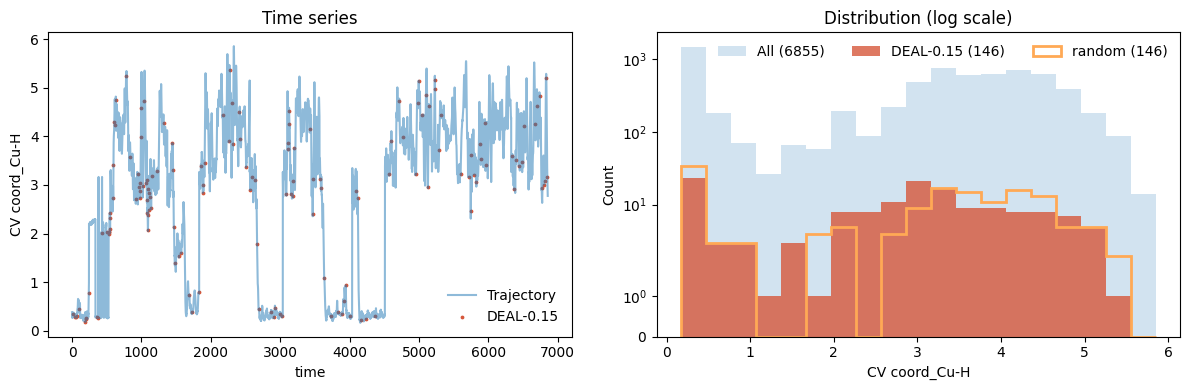

In [13]:
threshold = 0.15
sel = colvar[f"selection_{threshold}"] == 1
cv = "coord_Cu-H"
cv_label = f"CV {cv}"
deal_label = f"DEAL-{threshold}"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex=False)
# Top panel: time series with selected points
colvar.plot("time", cv, alpha=0.5, ax=ax1, label='Trajectory')
colvar[sel].plot.scatter("time", cv, c="fessa6", s=3, ax=ax1, label=deal_label)
ax1.set_title("Time series")
ax1.set_ylabel(cv_label)
ax1.legend(frameon=False)

# Bottom panel: histogram with selections
bins = np.linspace(colvar[cv].min(), colvar[cv].max(), 20)
colvar.hist(cv, bins=bins, ax=ax2, alpha=0.2, label=f"All ({len(colvar)})")
colvar[sel].hist(cv, bins=bins, ax=ax2, alpha=0.8, color="fessa6", label=deal_label+" ({})".format(sel.sum()))
colvar.sample(n=(sel == 1).sum(), random_state=42).hist(
    cv, bins=bins, ax=ax2, alpha=1, color="fessa5", linewidth=2, label="random"+" ({})".format(sel.sum()), histtype="step"
)

ax2.set_xlabel(cv_label)
ax2.set_ylabel("Count")
ax2.set_title("Distribution (log scale)")
ax2.set_yscale("symlog")
ax2.legend(frameon=False,ncol=3)
ax2.grid(False)

plt.tight_layout()
plt.savefig('imgs/analysis.png',bbox_inches='tight', dpi=300)
plt.show()

Available CVs: Index(['time', 'coord_Cu-O', 'coord_Cu-C', 'coord_Cu-H', 'coord_O-C',
       'coord_O-H', 'coord_C-H', 'walker', 'selection_0.05', 'selection_0.1',
       'selection_0.15', 'selection_0.2'],
      dtype='object')


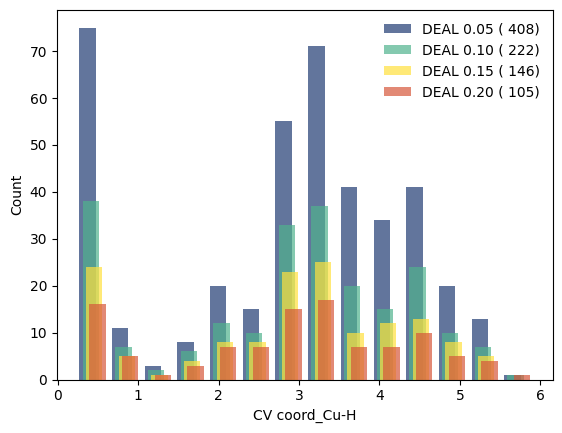

In [14]:
from deal.utils import compute_histogram

print("Available CVs:",colvar.columns)

cv = "coord_Cu-H"
cv_label = f"CV {cv}"
fig, ax = plt.subplots()

cv_all = colvar[cv]
bins_cv = np.linspace(cv_all.min(),cv_all.max(),15)
x,h = compute_histogram(cv_all,bins=bins_cv)
width = (x[1]-x[0])/2
offset = width/5

# ax.bar(x,h,width=width,label=f'Input ({len(colvar)})',alpha=0.5,color='grey',zorder=0)

colors = mpl.colormaps['fessa'](np.linspace(0, 1, len(deal_thresholds)))
for i, threshold in enumerate(deal_thresholds):
    sel = colvar[f"selection_{threshold}"] == 1
    x,h = compute_histogram(colvar.loc[sel, cv],bins=bins_cv)
    ax.bar(x + i*offset, h, width=width, label=f'DEAL {threshold:3.2f} ({sel.sum():4d})', alpha=0.7, color=colors[i])
ax.set_xlabel(cv_label)
ax.set_ylabel('Count')
# ax.set_yscale('log')
ax.legend(frameon=False)
plt.show()

**Note:** Even with large thresholds (few data points selected), DEAL still captures relevant structures across the configuration space.

## View selected structures with chemiscope

Create chemiscope file if not already created

In [16]:
from deal.utils import create_chemiscope_input
import os

threshold = 0.15
traj_path = f'b_selection/deal_{threshold}_selected.xyz'
chemiscope_output = traj_path.replace('_selected.xyz', '_chemiscope.json.gz')

if not os.path.exists(chemiscope_output):
    chemiscope_input = create_chemiscope_input(trajectory = traj_path,
                                            colvar = "a_input/COLVAR",
                                            cvs = ['frame','energy','colvar.*'], # '*'
                                            filename = chemiscope_output,
                                            verbose = True)
else:
    print(f'Chemiscope input {chemiscope_output} already exists.')

Chemiscope input b_selection/deal_0.15_chemiscope.json.gz already exists.


Visualize inside the notebook or upload the created file to https://chemiscope.org/

In [17]:
import chemiscope

chemiscope.show_input(chemiscope_output)

<ChemiscopeWidget(meta={'name': 'DEAL selection'}, settings={'structure': [{'atoms': False, 'bonds': False, 's…